In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Sklearn
# ==============================================================================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# MLflow
# ==============================================================================
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# TensorFlow
# ==============================================================================
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2

import datetime

2.15.0


# Load Data

In [ ]:
#!wget https://github.com/isaacmenchaca97/hospital_wait_time_prediction/releases/download/v1.0.0/ARTICLE.tar.gz
# !wget https://github.com/isaacmenchaca97/hospital_wait_time_prediction/releases/download/v1.0.0/EDIESCA.tar.gz

#!tar -xzvf ARTICLE.tar.gz
# !tar -xzvf EDIESCA.tar.gz

In [ ]:
# Select target and features
df_regression = pd.read_csv('../data/processed/EDIESCA.csv')
X = df_regression.drop(columns=['tiempo_total'])
y = df_regression['tiempo_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Check if TPU is available
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # No need to specify TPU address if on Colab
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  print("Running on TPU")
  print("All devices: ", tf.config.list_logical_devices('TPU'))
except ValueError: # If TPU is not found, use default strategy
  strategy = tf.distribute.get_strategy()
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print("Running on CPU")
  else:
    print("Running on GPU")


Running on CPU


# ANN Model

##### Layers

In [ ]:
def create_model():
  model = Sequential()

  model.add(Input(shape=(X_train.shape[1],)))  # Use Input layer to define input shape

  model.add(Dense(128, kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(64, kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(32, kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(1))
  return model


##### Model Fit

In [ ]:
# Free session memori
tf.keras.backend.clear_session()

# Set TensorBoard
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

with strategy.scope():
# with tf.device('/device:GPU:0'):
  model = create_model()
  initial_learning_rate = 0.005
  optimizer = RMSprop(learning_rate=initial_learning_rate)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

  # Fit model
  history = model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      epochs=300,
      batch_size=64,
      callbacks=[model_checkpoint, tensorboard_callback, early_stopping, reduce_lr],
      verbose=1,
  )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/300
2668/2675 [============================>.] - ETA: 0s - loss: 627.7030 - mae: 19.7160
Epoch 1: val_loss improved from inf to 550.03839, saving model to best_model.keras
2675/2675 [==============================] - 14s 5ms/step - loss: 627.5956 - mae: 19.7154 - val_loss: 550.0384 - val_mae: 18.5646 - lr: 0.0050
Epoch 2/300
2675/2675 [==============================] - ETA: 0s - loss: 550.7484 - mae: 18.7049
Epoch 2: val_loss improved from 550.03839 to 545.13977, saving model to best_model.keras
2675/2675 [==============================] - 13s 5ms/step - loss: 550.7484 - mae: 18.7049 - val_loss: 545.1398 - val_mae: 18.4049 - lr: 0.0050
Epoch 3/300
2668/2675 [============================>.] - ETA: 0s - loss: 546.2878 - mae: 18.6103
Epoch 3: val_loss improved from 545.13977 to 540.88947, saving model to best_model.keras
2675/2675 [==============================] - 12s 5ms/step - loss: 546.39

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 531.9284057617188
Test accuracy: 18.254505157470703


In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 48101), started 1:57:03 ago. (Use '!kill 48101' to kill it.)

<IPython.core.display.Javascript object>

##### Results

1338/1338 [==============================] - 5s 3ms/step
Root Mean Squared Error (RMSE): 22.925127414250785
Mean Squared Error (MSE): 525.5614669596329
Coeficiente de determinación (R^2): 0.06944904227895687
Mean Absolute Error (MAE): 18.288478070018446
        Actual  Predicted
41531     50.0  47.648006
159338    48.0  49.663967
176509    38.0  49.906174
76017     87.0  60.181221
149067    72.0  53.965832
131905    74.0  55.232037
148674    62.0  55.141773
24385     62.0  51.763355
58555     35.0  50.473499
126597    28.0  41.730701


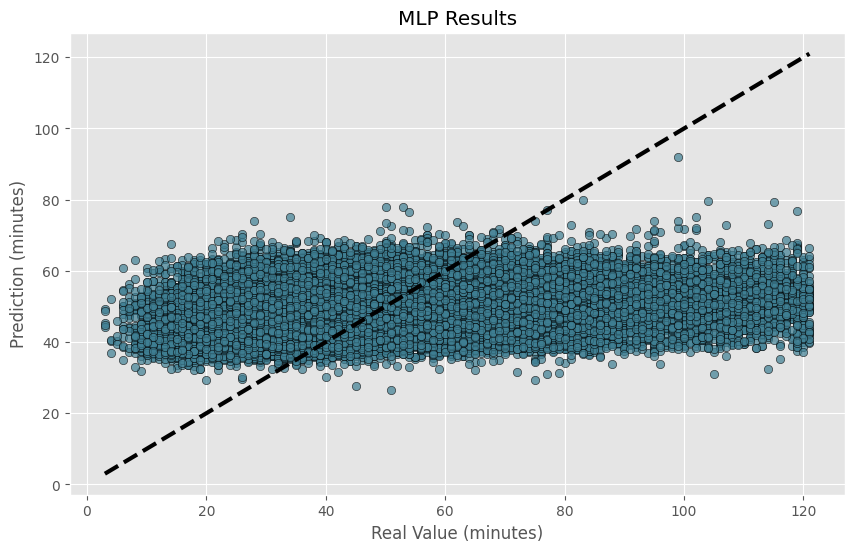

loss 523.4741821289062
val_loss 530.3899536132812
mae 18.120094299316406
val_mae 18.172170639038086


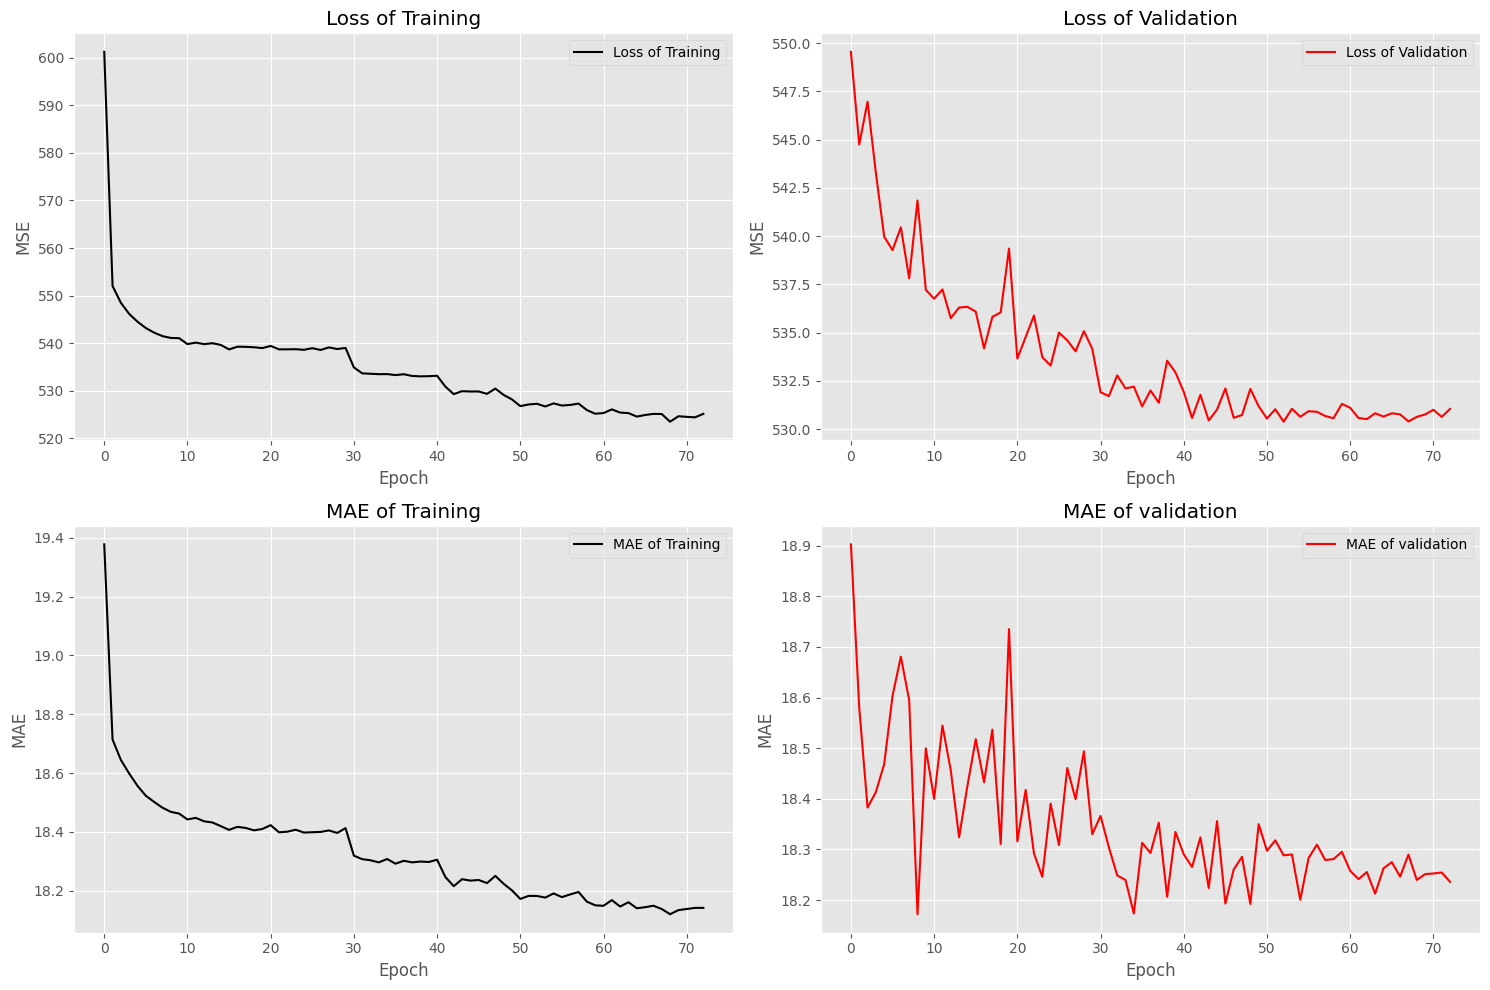

In [ ]:
# Load best model
model_ann = load_model("best_model.keras")

# Predicción
y_pred = model_ann.predict(X_test)

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color="#3f7f93")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Real Value (minutes)')
plt.ylabel('Prediction (minutes)')
plt.title('MLP Results')
plt.show()

# Imprimir las claves de history.history
print(f"loss {min(history.history['loss'])}")
print(f"val_loss {min(history.history['val_loss'])}")
print(f"mae {min(history.history['mae'])}")
print(f"val_mae {min(history.history['val_mae'])}")

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Graficar la pérdida de entrenamiento
axs[0, 0].plot(history.history['loss'], label='Loss of Training', color="black")
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_title('Loss of Training')
axs[0, 0].legend()

# Graficar la pérdida de validación
axs[0, 1].plot(history.history['val_loss'], label='Loss of Validation', color="red")
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].set_title('Loss of Validation')
axs[0, 1].legend()

# Graficar MAE de entrenamiento
axs[1, 0].plot(history.history['mae'], label='MAE of Training', color="black")
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('MAE of Training')
axs[1, 0].legend()

# Graficar MAE de validación
axs[1, 1].plot(history.history['val_mae'], label='MAE of validation', color="red")
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('MAE of validation')
axs[1, 1].legend()

# Ajustar diseño para evitar solapamiento
plt.tight_layout()
plt.show()